#### Input

In [22]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [23]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

from helpers import plot_class
from helpers import plot_dicts_nue
from helpers import helpfunction as helper

<IPython.core.display.Javascript object>

In [24]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [25]:
run = 1
input_dir = "./input/23Nov/".format(run)
output_dir = "./output/run{}/".format(run)

<IPython.core.display.Javascript object>

In [26]:
%%time
data = pickle.load(open(input_dir+"after_training_run{}.pckl".format(run), 'rb'))
samples = list(data.keys())

CPU times: user 578 ms, sys: 962 ms, total: 1.54 s
Wall time: 1.89 s


<IPython.core.display.Javascript object>

In [27]:
data["nue"]["daughters"].query("nslice>0")["category"].value_counts()

1     104535
11     85622
5      34655
10     14372
3         28
31        25
Name: category, dtype: int64

<IPython.core.display.Javascript object>

In [28]:
# Add the category cosmic:
for s in samples:
    if s not in helper.data_samples:
        cosmic = (data[s]["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            data[s]["daughters"]["category"] != 5
        )
        data[s]["daughters"].loc[cosmic, "category"] = 4

<IPython.core.display.Javascript object>

In [29]:
nue_frame = data["nue"]["daughters"]
nue_mc = data["nue"]["mc"]

<IPython.core.display.Javascript object>

In [30]:
title_str = "MicroBooNE Run{}: {:.1e} POT".format(run, data["on"]["pot"])

<IPython.core.display.Javascript object>

In [31]:
plotter = plot_class.Plotter(data, signal="nue", genie_version='mcc9')

Initialisation completed!


<IPython.core.display.Javascript object>

In [32]:
del data

<IPython.core.display.Javascript object>

### Evaluation

In [33]:
q_s = "(select & e_candidate)"

<IPython.core.display.Javascript object>

In [34]:
print(nue_frame.query("nslice>0")["true_category"].value_counts())
print()
print(nue_frame.query(q_s)["category"].value_counts())
print()
print(nue_frame.query(q_s)["interaction"].value_counts())

3    110733
2     90469
6     22863
1     15092
4        61
5        19
Name: true_category, dtype: int64

11    8965
1     4602
10    1658
5      189
4       94
Name: category, dtype: int64

0     7316
1     4946
10    1745
2     1464
3       37
Name: interaction, dtype: int64


<IPython.core.display.Javascript object>

In [35]:
print(pd.Series(nue_mc["category"]).value_counts())
print()
print(pd.Series(nue_mc["interaction"]).value_counts())
print()
print(pd.Series(nue_mc["true_category"]).value_counts())

11    28544
1     24335
0     18474
5     11509
10     6459
3         8
31        6
dtype: int64

0     34353
1     32732
2     12740
10     9196
3       314
dtype: int64

2    36688
3    30568
6    13452
1     8595
4       28
5        4
dtype: int64


<IPython.core.display.Javascript object>

### Plots

#### Signal sample plots

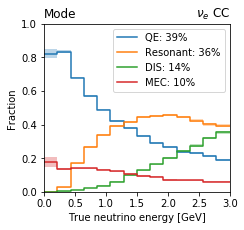

<IPython.core.display.Javascript object>

In [36]:
cats = [0, 1, 2, 10]
field = "nu_e"
x_min = 0
x_max = 3
n_bins = 15

fig, ax = plt.subplots(ncols=1, figsize=(3.5, 3.3))

for cat in cats:
    den = nue_mc[field]
    num = nue_mc[field][nue_mc["interaction"] == cat]

    den_w = nue_mc["weightSpline"]
    num_w = nue_mc["weightSpline"][nue_mc["interaction"] == cat]

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax.step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plotter.dicts.int_labels[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax.set_title(r"$\nu_e$ CC", loc="right")
ax.set_title("Mode", loc="left")
ax.set_xlabel("True neutrino energy [GeV]")
ax.set_ylabel("Fraction")
ax.set_ylim(0, 1)
ax.set_xlim(x_min, x_max)
ax.legend(loc="upper right")

fig.tight_layout()

fig.savefig(output_dir + "truth_int.pdf", bbox_inches="tight")

/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:382: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h
Purity: 0.13%
Purity: 2.09%
Purity: 38.20%
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:382: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h
Purity: 0.13%
Purity: 2.09%
Purity: 38.20%
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:382: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h
Purity: 0.13%
Purity: 2.09%
Purity: 38.20%


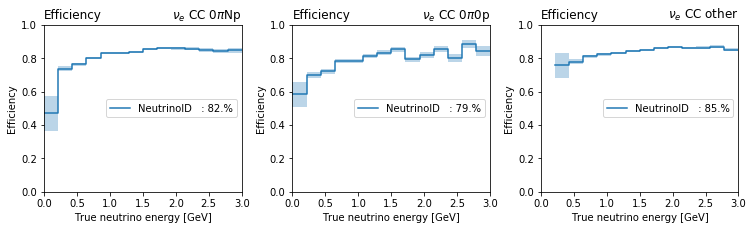

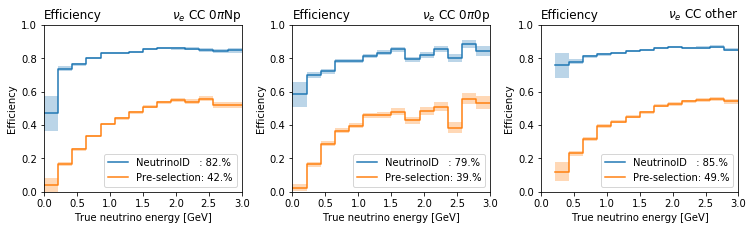

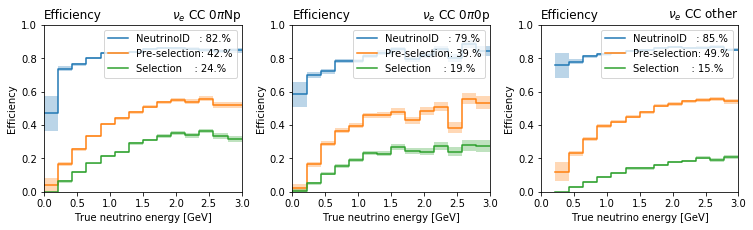

<IPython.core.display.Javascript object>

In [37]:
# eff per cat
cats = {2: 11, 1: 10, 3: 1}
field = "nu_e"
x_min = 0
x_max = 3
n_bins = 15
selectors = [
    "daughter==0",
    "e_candidate & preselect",
    "e_candidate & select",
]  # q_s
labs = ["NeutrinoID", "Pre-selection", "Selection"]

for i in range(3):
    fig, axes = plt.subplots(ncols=3, figsize=(10.5, 3.3))

    for cat, ax in zip(cats.keys(), axes):
        for selector, lab in zip(selectors[: (i + 1)], labs):
            num = nue_frame.query(selector).query("true_category==@cat")[field]
            den = nue_mc[field][nue_mc["true_category"] == cat]

            num_w = nue_frame.query(selector).query("true_category==@cat")[
                "weightSpline"
            ]
            den_w = nue_mc["weightSpline"][nue_mc["true_category"] == cat]

            eff, unc_low, unc_up, edges = plot_class.efficiency_post(
                num,
                den,
                num_w=num_w,
                den_w=den_w,
                n_bins=n_bins,
                x_min=x_min,
                x_max=x_max,
            )
            ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
            ax.step(
                edges,
                eff,
                where="post",
                label="{0:<13}: {1:#.2g}%".format(lab, sum(num_w) / sum(den_w) * 100),
            )
        ax.set_title(plotter.dicts.category_labels[cats[cat]], loc="right")
        ax.set_title("Efficiency", loc="left")
        ax.set_xlabel("True neutrino energy [GeV]")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1)
        ax.set_xlim(x_min, x_max)
        if i == 0:
            ax.legend(loc="center right")
        elif i == 1:
            ax.legend(loc="lower right")
        else:
            ax.legend(loc="upper right")

    fig.tight_layout()

    for selector in selectors:
        print(
            "Purity: {:.2f}%".format(
                100 * plotter.get_purity(selector, cats.values())
            )
        )
    fig.savefig(output_dir + "efficiency_cat_" + str(i) + ".pdf", bbox_inches="tight")

/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:382: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h


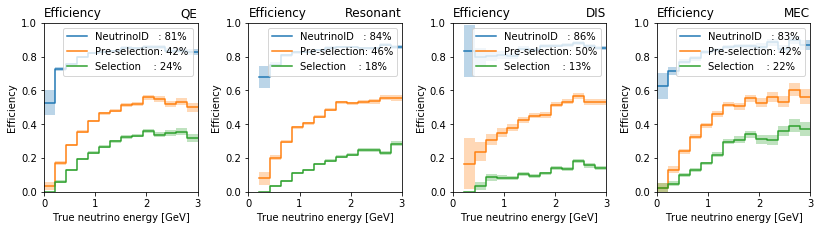

<IPython.core.display.Javascript object>

In [38]:
# eff per mode
cats = [0, 1, 2, 10]
field = "nu_e"
x_min = 0
x_max = 3
n_bins = 15
selectors = [
    "n_pfps>0 & daughter==0",
    "e_candidate & preselect",
    "e_candidate & select",
]  # q_s
labs = ["NeutrinoID", "Pre-selection", "Selection"]
fig, axes = plt.subplots(ncols=4, figsize=(11.5, 3.3))

for cat, ax in zip(cats, axes):
    for selector, lab in zip(selectors, labs):
        num = nue_frame.query(selector).query("interaction==@cat & nueccinc")[field]
        den = nue_mc[field][(nue_mc["interaction"] == cat) & nue_mc["nueccinc"] == 1]

        num_w = nue_frame.query(selector).query("interaction==@cat & nueccinc")[
            "weightSpline"
        ]
        den_w = nue_mc["weightSpline"][
            (nue_mc["interaction"] == cat) & nue_mc["nueccinc"] == 1
        ]

        eff, unc_low, unc_up, edges = plot_class.efficiency_post(
            num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
        )
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{0:<13}: {1:.0f}%".format(lab, sum(num_w) / sum(den_w) * 100),
        )
    ax.set_title(plotter.dicts.int_labels[cat], loc="right")
    ax.set_title("Efficiency", loc="left")
    ax.set_xlabel("True neutrino energy [GeV]")
    ax.set_ylabel("Efficiency")
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)
    ax.legend(loc="upper right")

fig.tight_layout()
fig.savefig(output_dir + "efficiency_int.pdf", bbox_inches="tight")

#### Data/MC comparison

[autoreload of helpers.plot_class failed: Traceback (most recent call last):
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    frame = next(frame_nfo.frame for frame_nfo in inspect.stack()
StopIteration
]
MC 

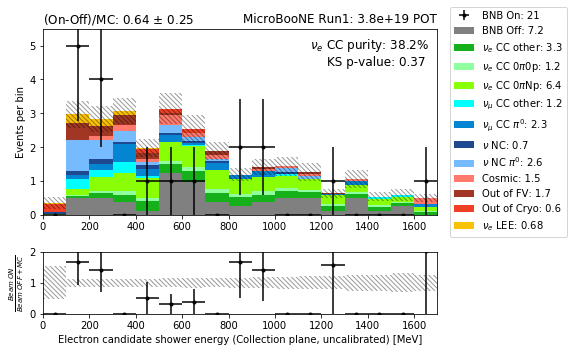

<IPython.core.display.Javascript object>

In [57]:
%%time
%autoreload
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(5 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio,purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax,
    "shr_energy_y_v",
    "Electron candidate shower energy (Collection plane, uncalibrated) [MeV]",
    N_bins=17,
    x_min=0,
    x_max=1700,
    query=q_s,
    legend=True,
    title_str=title_str,
    kind="cat",
    y_max_scaler=1.1
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.98,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

#ax[0].set_ylim(0, 0.3)
fig.tight_layout()
fig.savefig(output_dir + "data_mc/nue_shower_energy_y.pdf", bbox_inches="tight")

In [ ]:
%%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(5 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio,purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "shr_tkfit_theta_v",
    "Electron candidate shower theta",
    N_bins=12,
    x_min=0,
    x_max=np.pi,
    query=q_s,
    legend=True,
    title_str=title_str,
    kind="event_category",
    y_max_scaler=1.2
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.98,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/nue_shower_theta.pdf", bbox_inches="tight")

In [ ]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "shr_energy_y_v",
    "Candidate shower energy (Collection plane, uncalibrated) [MeV]",
    N_bins=18,
    x_min=50,
    x_max=500,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.1,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.98,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_shower_E_pdg.pdf", bbox_inches="tight")

In [ ]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "shr_energy_y_v",
    "Candidate shower energy (Collection plane, uncalibrated) [MeV]",
    N_bins=18,
    x_min=50,
    x_max=500,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.98,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_shower_E.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    ncols=3, nrows=2, figsize=(15, 5), gridspec_kw={"height_ratios": [3, 1]}
)


field_arr = ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
lab_arr = [
    "Neutrino candidate vx [cm]",
    "Neutrino candidate vy [cm]",
    "Neutrino candidate vz [cm]",
]
x_min_arr = helper.lower + np.array([10, 10, 10])
x_max_arr = helper.upper - np.array([10, 10, 50])

for i, (x_min, x_max, lab, field) in enumerate(
    zip(x_min_arr, x_max_arr, lab_arr, field_arr)
):
    ratio, purity, ks_p = plothelp.plot_panel_data_mc(
        data,
        ax.T[i],
        field,
        lab,
        N_bins=30,
        x_min=x_min,
        x_max=x_max,
        query="e_candidate>0 & preselect",
        legend=(i == 2),
        title_str=title_str.split("NE")[-1],
        kind="event_category",
        y_max_scaler=1.2,
    )
    ax[0][i].text(
        ax[0][i].get_xlim()[1] * 0.98,
        ax[0][i].get_ylim()[1] * 0.9,
        "KS p-value: {0:<5.2f}".format(ks_p),
        horizontalalignment="right",
        fontsize=12,
    )

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_vtx.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(11, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "shr_tkfit_phi_v",
    "Electron candidate phi",
    N_bins=20,
    x_min=-np.pi,
    x_max=np.pi,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "shr_tkfit_theta_v",
    "Electron candidate theta",
    N_bins=20,
    x_min=0,
    x_max=np.pi,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_angles.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(11, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "shr_dist_v",
    "Electron candidate vertex distance [cm]",
    N_bins=20,
    x_min=0,
    x_max=20,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "shr_tkfit_dedx_y_v",
    r"Electron candidate $\frac{dE}{dx}$ [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_shwrfields.pdf", bbox_inches="tight")

In [ ]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "score",
    "Electron Identification score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.6,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_e_score.pdf", bbox_inches="tight")

In [ ]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "score",
    "Other Daughters Identification score",
    N_bins=29,
    x_min=0,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.7,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_daughter_score.pdf", bbox_inches="tight")

In [ ]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "score_event",
    "Event Identification score",
    N_bins=29,
    x_min=0,
    x_max=1,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.6,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_event_score.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(11, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "shr_tkfit_phi_v",
    "Electron candidate phi",
    N_bins=12,
    x_min=-np.pi,
    x_max=np.pi,
    legend=False,
    query=q_s,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)

ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "shr_tkfit_theta_v",
    "Electron candidate theta",
    N_bins=12,
    x_min=0,
    x_max=np.pi,
    legend=True,
    query=q_s,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.2,
)
x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)

ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/after_angles.pdf", bbox_inches="tight")

In [ ]:
%time
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(5 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "trk_llr_pid_score_v",
    "Other Daughters Identification score",
    N_bins=29,
    x_min=-1,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.7,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_daughter_nico_zoom.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(11, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "shr_moliere_avg_v",
    "Average Moliere Radius",
    N_bins=20,
    x_min=0,
    x_max=50,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "shr_tkfit_gap10_dedx_y_v",
    r"Electron candidate $\frac{dE}{dx}$ [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=6,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_moliere.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(11, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "trk_min_cos",
    "Most opposite pfp angle (cos)",
    N_bins=20,
    x_min=-1,
    x_max=1,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "shr_subclusters_v",
    r"shr_subclusters_v",
    N_bins=20,
    x_min=0,
    x_max=50,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.2,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/pre_clustershwr.pdf", bbox_inches="tight")

In [ ]:
### PLOT the containment!
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(7, 3))

plot_data = [
    data["off"]["daughters"].query("e_candidate>0 & preselect")["contained_sps_ratio"],
    data["nue"]["daughters"].query("e_candidate>0 & preselect & nueccinc")[
        "contained_sps_ratio"
    ],
    data["off"]["daughters"].query("e_candidate>0 & preselect")["contained_fraction"],
    data["nue"]["daughters"].query("e_candidate>0 & preselect & nueccinc")[
        "contained_fraction"
    ],
]
ax[0].hist(plot_data[0:2], bins=50, density=True, label=["Ext", "Nue"], histtype="step")
ax[0].legend(loc="upper center")
ax[0].set_xlabel("contained_sps_ratio")
ax[0].set_yscale("log")

ax[1].hist(plot_data[2:4], bins=50, density=True, label=["Ext", "Nue"], histtype="step")
ax[1].legend(loc="upper center")
ax[1].set_xlabel("contained_fraction")
ax[1].set_yscale("log")

fig.tight_layout()